In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
import numpy as np
import matplotlib_inline
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [82]:
epochs = 50
batch_size = 32
learning_rates_list = np.logspace(np.log10(.0001), np.log10(.1), 6)
optimizers_dict = {
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop,
    "Adam": torch.optim.Adam
}

In [83]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(784, 128)
        self.hidden1 = nn.Linear(128, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = fn.relu(self.input(x))
        x = fn.relu(self.hidden1(x))
        x = fn.relu(self.hidden2(x))

        return self.output(x)

In [84]:
def create_data():
    data = np.loadtxt(open("../../datasets/mnist_train_small.csv", "rb"), delimiter=",")

    labels = data[:, 0]
    data = MinMaxScaler().fit_transform(data[:, 1:])

    data_tensor = torch.tensor(data).float()
    labels_tensor = torch.tensor(labels).long()

    train_data, test_data, train_labels, test_labels = train_test_split(
        data_tensor,
        labels_tensor,
        test_size=.1,
        shuffle=True
    )

    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_dataset.tensors[0].shape[0]
    )

    return train_loader, test_loader

In [85]:
def create_model(optim, lr):
    model = MnistModel()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=lr)

    return model, loss_fn, optimizer

In [86]:
def train_model(model, loss_fn, optimizer, train_loader, test_loader):
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    train_acc = torch.zeros(epochs).to(device)
    test_acc = torch.zeros(epochs).to(device)

    for epoch_no in range(epochs):
        model.train()

        batch_acc = torch.zeros(len(train_loader)).to(device)

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = loss_fn(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            matches = torch.argmax(output, dim=1) == target
            matches_float = matches.float()
            accuracy = 100 * torch.mean(matches_float)
            batch_acc[batch_idx] = accuracy

        train_acc[epoch_no] = torch.mean(batch_acc)

        model.eval()
        data, target = next(iter(test_loader))
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(data)

        matches = torch.argmax(output, dim=1) == target
        matches_float = matches.float()
        accuracy = 100 * torch.mean(matches_float)
        test_acc[epoch_no] = accuracy

    return train_acc, test_acc

In [87]:
def run_the_experiment():
    train_acc = torch.zeros((len(optimizers_dict), len(learning_rates_list), epochs)).to(device)
    test_acc = torch.zeros((len(optimizers_dict), len(learning_rates_list), epochs)).to(device)

    train_loader, test_loader = create_data()

    for optim_idx, (optim_name, optim) in enumerate(optimizers_dict.items()):
        for lr_idx, lr in enumerate(learning_rates_list):
            model, loss_fn, optimizer = create_model(optim, lr)

            tmp_train_acc, tmp_test_acc = train_model(model, loss_fn, optimizer, train_loader, test_loader)

            train_acc[optim_idx, lr_idx] = tmp_train_acc
            test_acc[optim_idx, lr_idx] = tmp_test_acc

            print(f"Optimizer: {optim_name}, Learning rate: {round(lr, 4)} - done!")

    return train_acc, test_acc

In [88]:
train_acc, test_acc = run_the_experiment()

Layers: SGD, Learning rate: 0.0001 - done!
Layers: SGD, Learning rate: 0.0004 - done!
Layers: SGD, Learning rate: 0.0016 - done!
Layers: SGD, Learning rate: 0.0063 - done!
Layers: SGD, Learning rate: 0.0251 - done!
Layers: SGD, Learning rate: 0.1 - done!
Layers: RMSprop, Learning rate: 0.0001 - done!
Layers: RMSprop, Learning rate: 0.0004 - done!
Layers: RMSprop, Learning rate: 0.0016 - done!
Layers: RMSprop, Learning rate: 0.0063 - done!
Layers: RMSprop, Learning rate: 0.0251 - done!
Layers: RMSprop, Learning rate: 0.1 - done!
Layers: Adam, Learning rate: 0.0001 - done!
Layers: Adam, Learning rate: 0.0004 - done!
Layers: Adam, Learning rate: 0.0016 - done!
Layers: Adam, Learning rate: 0.0063 - done!
Layers: Adam, Learning rate: 0.0251 - done!
Layers: Adam, Learning rate: 0.1 - done!


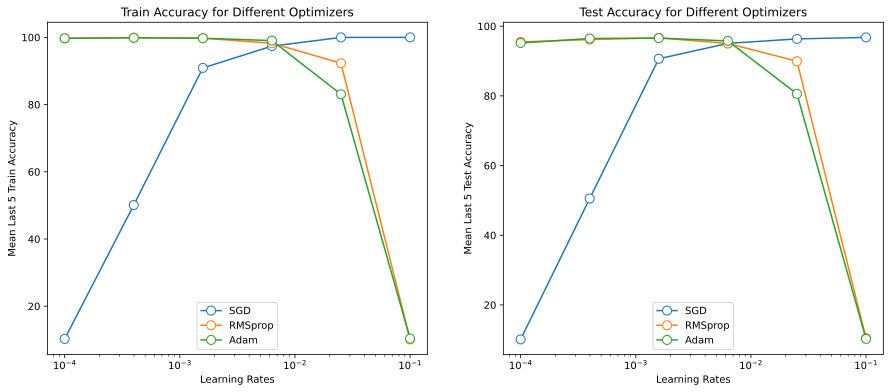

In [95]:
mean_last_10_train_acc = train_acc[:, :, -10:].mean(dim=2).cpu().numpy()
mean_last_10_test_acc = test_acc[:, :, -10:].mean(dim=2).cpu().numpy()

optimizers_names = list(optimizers_dict.keys())

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i in range(mean_last_10_train_acc.shape[0]):
    ax[0].plot(learning_rates_list, mean_last_10_train_acc[i, :], "o-", markerfacecolor="w", markersize=9,
        label=optimizers_names[i])

ax[0].legend()
ax[0].set_xscale("log")
ax[0].set_xlabel("Learning Rates")
ax[0].set_ylabel("Mean Last 5 Train Accuracy")
ax[0].set_title("Train Accuracy for Different Optimizers")

for i in range(mean_last_10_test_acc.shape[0]):
    ax[1].plot(learning_rates_list, mean_last_10_test_acc[i, :], "o-", markerfacecolor="w", markersize=9,
        label=optimizers_names[i])

ax[1].legend()
ax[1].set_xscale("log")
ax[1].set_xlabel("Learning Rates")
ax[1].set_ylabel("Mean Last 5 Test Accuracy")
ax[1].set_title("Test Accuracy for Different Optimizers")

plt.show()